In [1]:
from utils_experiment import (
    load_data,
    filter_data_exp_1,
    AutoGluonProcessor,
    fit_predictors_local,
    fit_predictors_global,
    get_model_list,
    create_output_directories,
    process_and_plot_forecasts,
)

In [2]:
import torch
print("Is cuda available? {}".format(torch.cuda.is_available()))
torch.cuda.get_device_name(torch.cuda.current_device())

Is cuda available? True


'Tesla T4'

## Experiment 1 Details

Experiment 1 serves as a baseline for comparing the effect of different window lengths for training. The data will be filtered to include only time series that are available in the time period. To investiage the effect of the time series by themselves, the number of covariates is kept constant across all time series and corresponds to the time series fully available from 1986. The specific time periods were chosen with the condition that between each interval, 5 or more new time series were introduced.

| Time Period - 2024     | Maximum number of covariates | Number of covariates used |
|--------------|:-----:| :-----:| 
| 1986 |   94  |   94  |  
| 1997 |   111  |  94  |  
| 2004 |   133  |   94  |  
| 2007 |   146  |  94  |  
| 2010 |   154  |  94  |  
| 2018 |   159  |  94  |  


The cut-off dates are set at 4 yearly intervals between 2020 and 2024. Since the minimum training length for a yearly interval is 2 years, 2020 is the earliest cut-off date we can use.


In [3]:
exp_test_description = "Full_Report"
report_sim_dates = open("/h/kupfersk/cfpr_2025/generate_forecasts/experiment_cutoff_dates.txt", 'r').read().split()
# report_sim_dates=report_sim_dates[:-1]

target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Dairy products and eggs',
     'Fish, seafood and other marine products',
     'Food purchased from restaurants',
     'Food',
     'Fruit, fruit preparations and nuts',
     'Meat',
     'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]

target_categories = [f"food_cpi: {col}" for col in target_categories]

start_year = 1986
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))


Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Dairy products and eggs
food_cpi: Fish, seafood and other marine products
food_cpi: Food purchased from restaurants
food_cpi: Food
food_cpi: Fruit, fruit preparations and nuts
food_cpi: Meat
food_cpi: Other food products and non-alcoholic beverages
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


## Load data

`all_data`: dataframe with all the food cpi variables and all the covariates from 1986 to 2024.\
`foodprice_df`: dataframe with only the food cpi variables from 1986 to 2024.\
`target_categories`: list of the names of the food cpi variables.\
`all_covariates`: dataframe with all the covariates from 1986 to 2024.

In [4]:
file_path = "/h/kupfersk/cfpr_2025/data/processed_data/all_select.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

In [5]:
# all_data = filter_data_exp_1(all_data, start_year)
processor = AutoGluonProcessor(all_data, target_categories)


# Experiment List

| AutoGluon Model \ Experiment      | local | global | global + covariates |
|--------------|:-----:| :-----: | :-----: |
| NaiveModel |   x  |   |  | 
| SeasonalNaiveModel|   x    |  |  | 
| AutoARIMAModel|   x   |  |  | 
| AutoETSModel|  x  |    |  | 
| DeepARModel|  x   | x |  x | 
| DLinearModel| x   | x |  x| 
| PatchTSTModel|  x   | x | x |   
|SimpleFeedForwardModel|  x   | x | x |   
| TemporalFusionTransformerModel| x  | x | x |   
| DirectTabularModel| x   | x | x | 
|RecursiveTabularModel|  x   | x | x |  
|ChronosModel|  x   | x | x | 

x - model type supported


# Main experiment loop - global models

5 main loops:
- The first loop goes through the list of years at which we want the time window to start, filters out the covariates that are not fully available from 1986.
- The second loop goes though the two experiment base (global and global+covariates)
- The third loop goes though 8 Autogluon models, excluding all statistical models (Naive, SeasonalNaive, AutoArima, AutoETS).
- The fourth loop goes through each of the yearly cut-off dates to trim the training data.
- The fifth loop goes through each of the 9 food categories, gets the training data in the AutoGluon format depending on the experiment base and plot each prediction period againt the actual values.

In [7]:
import json

# Load the dictionary from the JSON file
with open('experiment_dict.json', 'r') as json_file:
    experiment_dict = json.load(json_file)
    
experiment_dict

{'Bakery and cereal products (excluding baby food)': ['exp7_Bakery and cereal products (excluding baby food).txt',
  'exp8_Bakery and cereal products (excluding baby food).txt',
  'exp1_corr_Bakery and cereal products (excluding baby food).txt',
  'exp5_geopolitical_Bakery and cereal products (excluding baby food).txt',
  'exp5_manufacturing_Bakery and cereal products (excluding baby food).txt',
  'exp5_economic_Bakery and cereal products (excluding baby food).txt',
  'exp5_climate_Bakery and cereal products (excluding baby food).txt',
  'exp1_human_Bakery and cereal products (excluding baby food).txt',
  'exp1_llm_Bakery and cereal products (excluding baby food).txt'],
 'Dairy products and eggs': ['exp5_climate_Dairy products and eggs.txt',
  'exp5_geopolitical_Dairy products and eggs.txt',
  'exp1_llm_Dairy products and eggs.txt',
  'exp5_manufacturing_Dairy products and eggs.txt',
  'exp8_Dairy products and eggs.txt',
  'exp1_human_Dairy products and eggs.txt',
  'exp7_Dairy product

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2018-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       141.90 GB / 188.59 GB (75.2%)
Disk Space Avail:   18010.00 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

['DeepARModel', 'DLinearModel', 'PatchTSTModel', 'SimpleFeedForwardModel', 'TemporalFusionTransformerModel', 'ChronosModel']
ag_global_all_DeepARModel
DeepARModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-26 13:32:24
Excluded model types: ['DirectTabular', 'RecursiveTabular']
Models that will be trained: ['DeepAR']
Training timeseries model DeepAR. Training for up to 599.9s of the 599.9s of remaining time.
	-0.6940       = Validation score (-MAPE)
	106.91  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 107.12 s
Best model: DeepAR
Best model score: -0.6940


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.694003       0.170803         106.910967          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR
Model not specified in predict, will default to the model with the best validation score: DeepAR


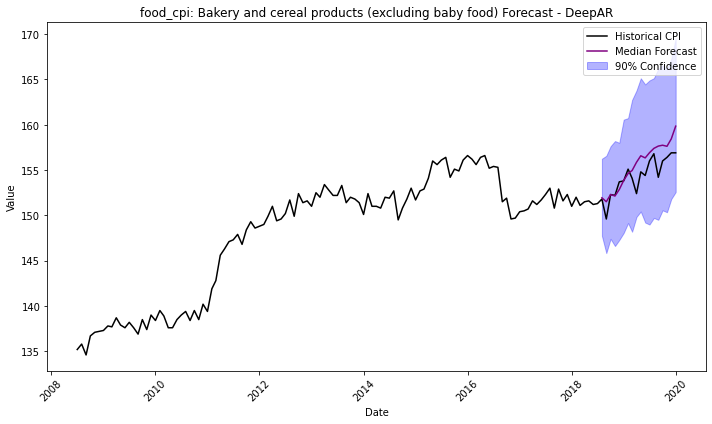

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2019-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.88 GB / 188.59 GB (74.2%)
Disk Space Avail:   18008.81 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.4120       = Validation score (-MAPE)
	196.51  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 196.70 s
Best model: DeepAR
Best model score: -0.4120
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.411979       0.166755         196.507832          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


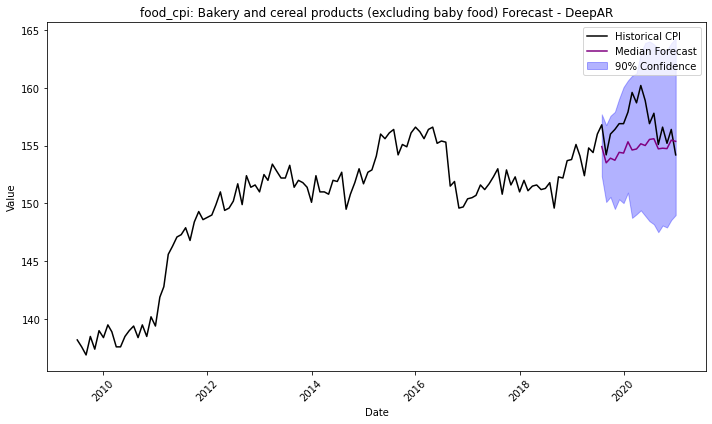

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2020-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.88 GB / 188.59 GB (74.2%)
Disk Space Avail:   18003.02 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.3633       = Validation score (-MAPE)
	192.45  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 192.64 s
Best model: DeepAR
Best model score: -0.3633
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.363267       0.171555         192.448622          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


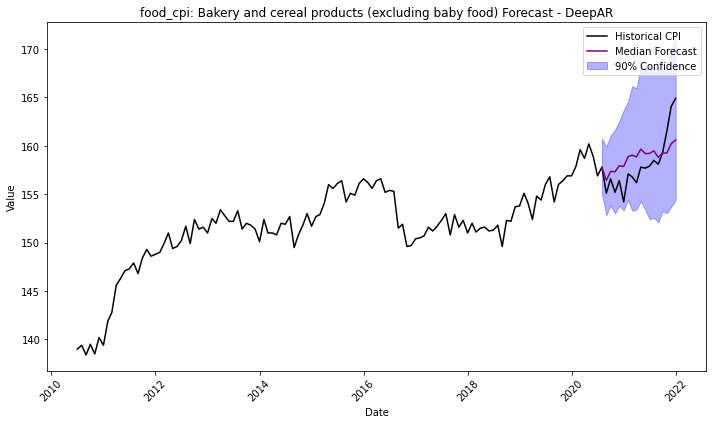

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2021-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.88 GB / 188.59 GB (74.2%)
Disk Space Avail:   17999.93 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.3505       = Validation score (-MAPE)
	197.62  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 197.82 s
Best model: DeepAR
Best model score: -0.3505
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.350493       0.172371          197.62232          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


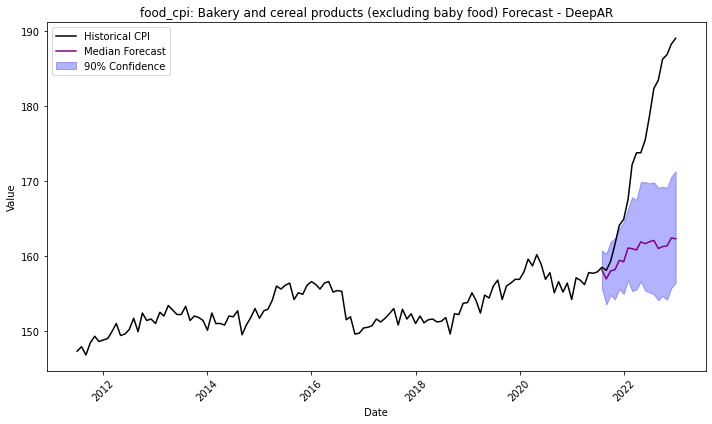

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2022-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.87 GB / 188.59 GB (74.2%)
Disk Space Avail:   17999.66 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.7375       = Validation score (-MAPE)
	194.19  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 194.37 s
Best model: DeepAR
Best model score: -0.7375
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.737499        0.16545         194.188769          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


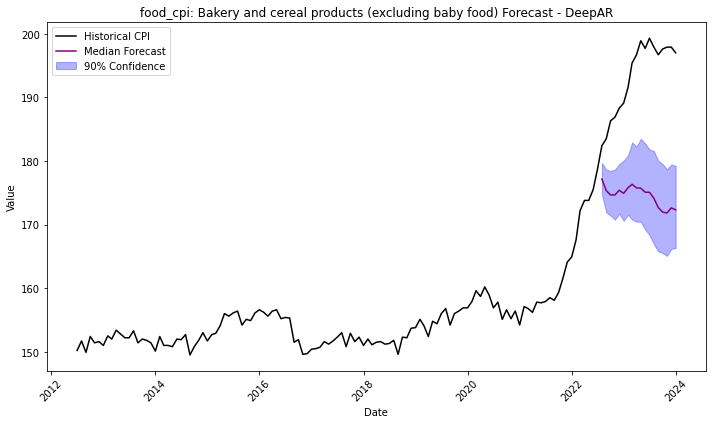

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2018-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.87 GB / 188.59 GB (74.2%)
Disk Space Avail:   17997.83 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.6905       = Validation score (-MAPE)
	202.52  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 202.75 s
Best model: DeepAR
Best model score: -0.6905
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.690502        0.16635         202.518735          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


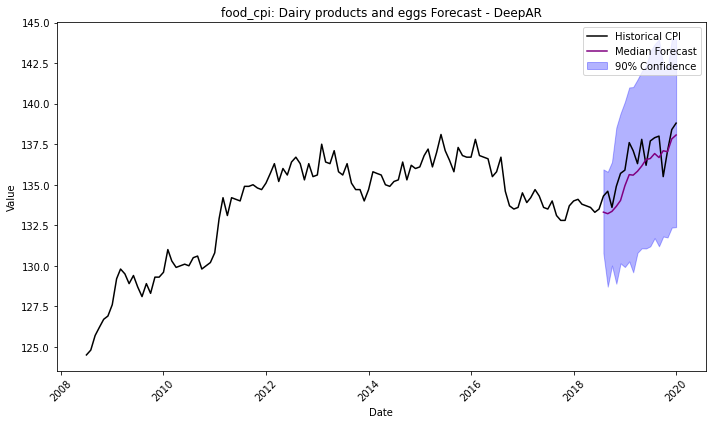

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2019-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.86 GB / 188.59 GB (74.2%)
Disk Space Avail:   17996.14 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.4120       = Validation score (-MAPE)
	200.26  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 200.49 s
Best model: DeepAR
Best model score: -0.4120
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.411979       0.166748         200.257873          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


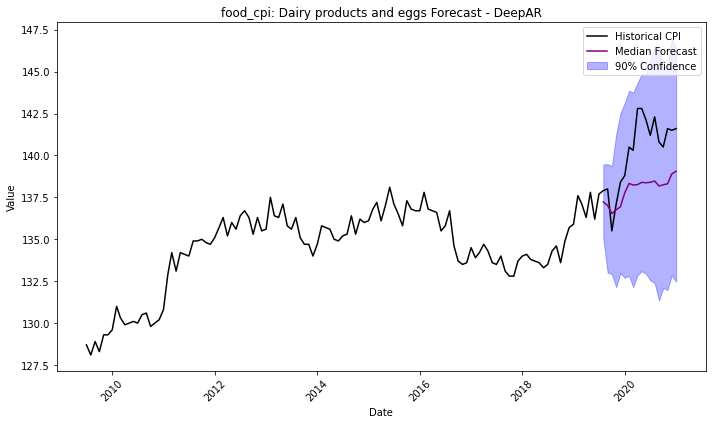

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2020-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.86 GB / 188.59 GB (74.2%)
Disk Space Avail:   17995.74 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.3633       = Validation score (-MAPE)
	195.49  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 195.72 s
Best model: DeepAR
Best model score: -0.3633
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.363267       0.166952         195.494815          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


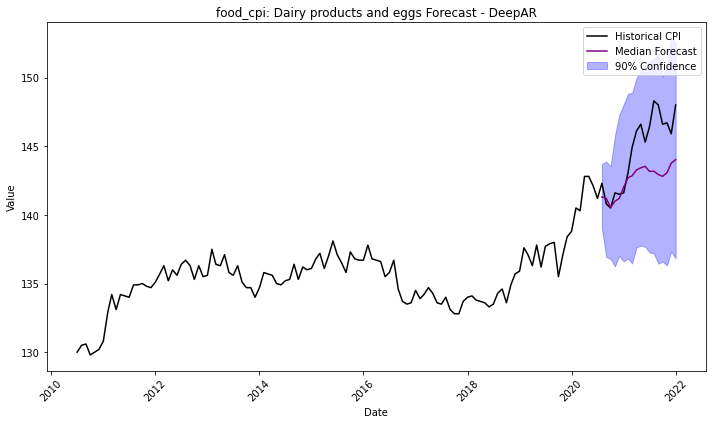

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2021-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.84 GB / 188.59 GB (74.1%)
Disk Space Avail:   17984.31 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.3505       = Validation score (-MAPE)
	203.82  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 204.05 s
Best model: DeepAR
Best model score: -0.3505
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.350493       0.168963          203.82053          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


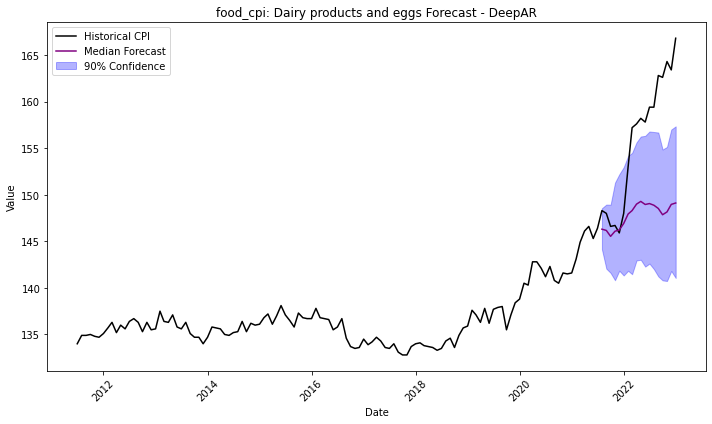

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2022-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.87 GB / 188.59 GB (74.2%)
Disk Space Avail:   17981.45 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.7375       = Validation score (-MAPE)
	197.34  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 197.57 s
Best model: DeepAR
Best model score: -0.7375
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.737499       0.171464         197.336172          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


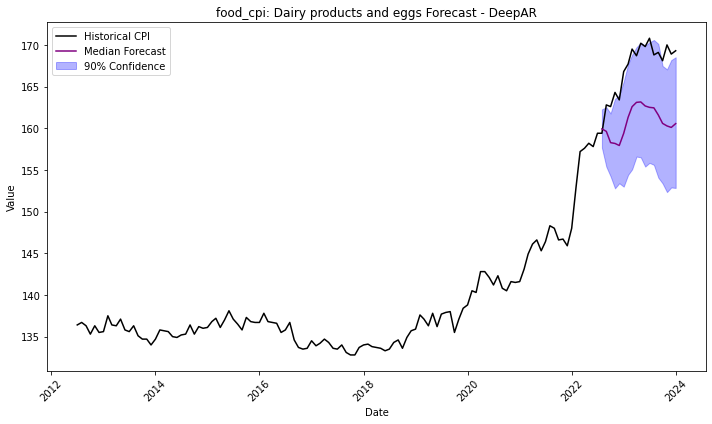

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2018-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.86 GB / 188.59 GB (74.2%)
Disk Space Avail:   17979.95 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.6905       = Validation score (-MAPE)
	203.52  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 203.75 s
Best model: DeepAR
Best model score: -0.6905
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.690502       0.168779         203.521967          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


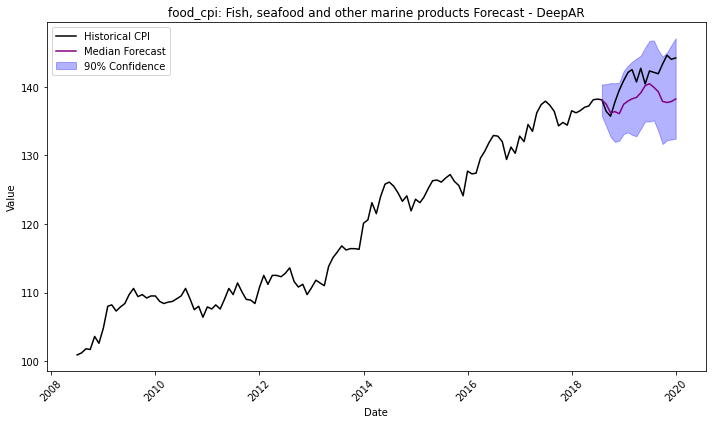

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2019-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.87 GB / 188.59 GB (74.2%)
Disk Space Avail:   17978.30 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.4120       = Validation score (-MAPE)
	201.75  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 201.98 s
Best model: DeepAR
Best model score: -0.4120
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.411979       0.167405         201.747658          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


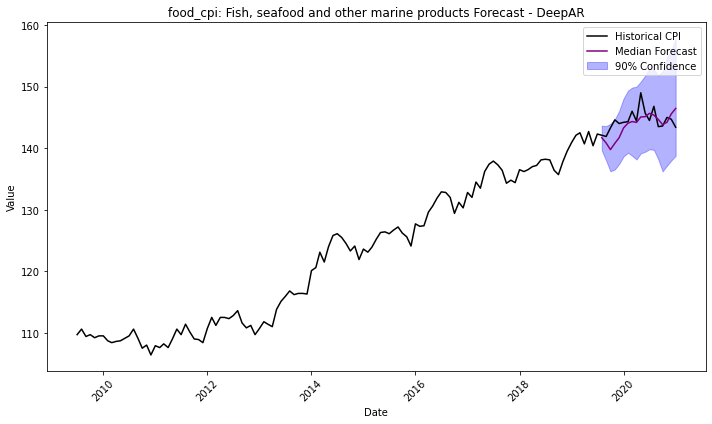

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2020-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.86 GB / 188.59 GB (74.2%)
Disk Space Avail:   17976.76 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.3633       = Validation score (-MAPE)
	202.37  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 202.60 s
Best model: DeepAR
Best model score: -0.3633
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.363267       0.171481         202.367788          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


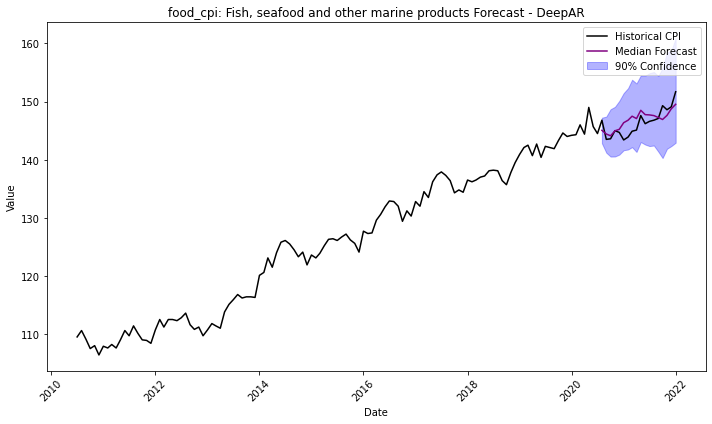

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2021-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.86 GB / 188.59 GB (74.2%)
Disk Space Avail:   17974.72 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.3505       = Validation score (-MAPE)
	193.20  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 193.43 s
Best model: DeepAR
Best model score: -0.3505
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.350493       0.172562         193.204208          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


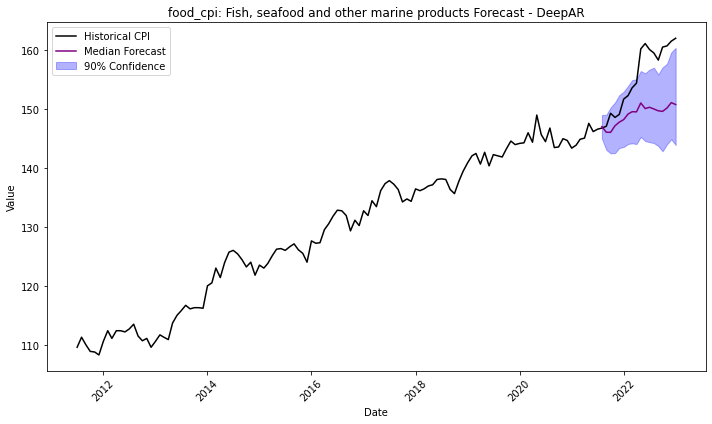

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2022-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.86 GB / 188.59 GB (74.2%)
Disk Space Avail:   17971.32 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


	-0.7375       = Validation score (-MAPE)
	195.37  s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 195.60 s
Best model: DeepAR
Best model score: -0.7375
Model not specified in predict, will default to the model with the best validation score: DeepAR


****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.737499       0.170573         195.368943          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: DeepAR


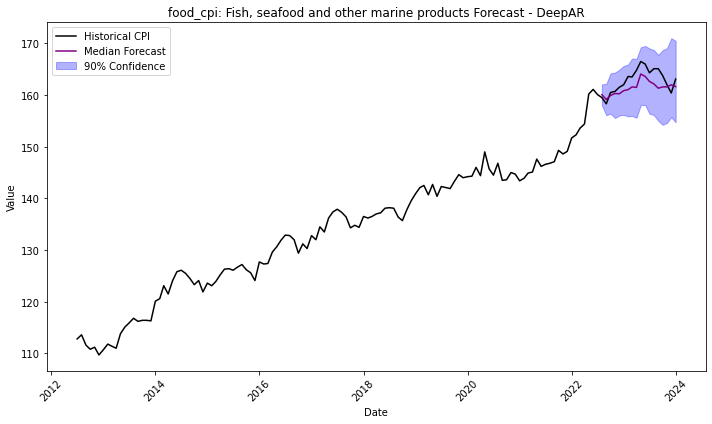

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './output/Full_Report/ag_global_all_DeepARModel_exp5_economic_/random_seed_42/2018-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       139.86 GB / 188.59 GB (74.2%)
Disk Space Avail:   17970.43 GB / 249006.62 GB (7.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'DeepARModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target

DeepARModel


In [ ]:
models_to_test = [
  'DeepARModel',
  'SimpleFeedForwardModel',
  'TemporalFusionTransformerModel',
  'ChronosModel'
]

EXP_BASE_LIST_GLOBAL = ["ag_global_all", "ag_global_cpi_with_covariates"]


for EXP_BASE in EXP_BASE_LIST_GLOBAL:
    EXP_MODEL_LIST = get_model_list(EXP_BASE)
    print(EXP_MODEL_LIST)

    for model_type in EXP_MODEL_LIST:
        
        if model_type not in models_to_test:
            continue
            print(model_type)
                

        EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"
        print(EXPERIMENT_NAME)

        for category in (target_categories):

            
            #For this specific category, collect the experiments that need to be run by filtering the data 
            FILT_EXPS = experiment_dict[category.split("food_cpi: ")[1]]
            
            for cutoff_date in report_sim_dates:
                
                for FILT_NUM in FILT_EXPS:
                    MOD_FILT_NUM = FILT_NUM.replace(category.split("food_cpi: ")[1], "").split('.txt')[0]
                    MOD_EXP_NAME = f"{EXPERIMENT_NAME}_{MOD_FILT_NUM}"
#                     print(FILT_NUM)
                                        
                    with open(f"/h/kupfersk/cfpr_2025/cfpr_variable_selection/Full_Report_Experiments/{FILT_NUM}", 'r') as file: 
                        # Use .strip() to remove any trailing newline or spaces
                        item_list = [line.strip() for line in file.readlines()]
                        filt_regressors = item_list
                        
                        
                    
                        
                    forecast_output_dir, plot_output_dir, training_output_dir, model_dir = (
                        create_output_directories(
                            exp_test_description,
                            start_year,
                            MOD_EXP_NAME,
                            cutoff_date,
                            random_seed
                        )
                    )

                    if "_covariates" in EXP_BASE:
                        train_data = processor.get_autogluon_global_with_covariates_df_filt(
                            cutoff_date, filt_regressors
                        )
                    else:
                        train_data = processor.get_autogluon_global_df_filt(cutoff_date, filt_regressors)

                    predictor = fit_predictors_global(model_type, model_dir, train_data, random_seed)


                    process_and_plot_forecasts(
                        predictor,
                        train_data,
                        category,
                        training_output_dir,
                        forecast_output_dir,
                        plot_output_dir,
                        foodprice_df,
                        cutoff_date
                    )

In [ ]:
FILT_NUM